In [1]:
import pandas as pd
import numpy as np
from datetime import date, datetime, time, timedelta
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

from sklearn import preprocessing

%config InlineBackend.figure_format = 'retina' 
%matplotlib inline

 
mpl.rcParams['lines.linewidth'] = 2

figsize=(12,9)

np.random.seed(238746)


import warnings
warnings.filterwarnings("ignore")

In [2]:
SplitTestDate = "2018-12-02"

In [3]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def split_date(X,y,d):
    X_te = X[d:]
    y_te = y[d:]
    X_tr = X[:d]
    y_tr = y[:d]
    return X_tr, X_te, y_tr, y_te 

def plot_results(ytrue, prediction, label):
    df_ytrue = pd.DataFrame(ytrue)
    df_ytrue['predicted'] =  prediction 
    plt.plot(df_ytrue[label],label='data')
    plt.plot(df_ytrue['predicted'],label='predicted')
    plt.xticks(rotation=45)
    mape = mean_absolute_percentage_error(df_ytrue[label],df_ytrue['predicted'])

    plt.title("Forecasting on Test Set MAPE=%.3f"%mape)
    plt.legend();
    plt.show()

In [4]:
quantile_transformer = preprocessing.QuantileTransformer(output_distribution='normal', random_state=123)
min_max_scaler = preprocessing.MinMaxScaler()

def scale(feature, scaler = min_max_scaler):
    size = len(feature)
    return scaler.fit_transform(np.array([feature]).reshape(size, 1)).T[0]
def unscale(scaled, original, scaler = min_max_scaler):
    size2 = len(scaled)
    size1 = len(original)
    return scaler.fit(np.array([original]).reshape(size1, 1)).inverse_transform(np.array([scaled]).reshape(size2, 1)).T[0]

In [5]:
df = pd.read_csv('processed_train.csv',index_col = 0)
df_test = pd.read_csv('processed_test.csv',index_col = 0)

df.date = df.date.apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))


In [6]:
df.head()

,date,sku,price,volume_on_promo w-1,sales w-1,scope,sales w-2,sales w-3,rolling1,rolling2,...,scaled_year,scaled_dayofyear,scaled_dayofmonth,scaled_weekofyear,scaled_target,target,group_A,group_B,BRAND2,BRAND4
799,2016-12-17,2704,2.50,0.516719,20456.0,0,NaN,NaN,20456.0,NaN,...,0.000000,0.961219,0.533333,0.960784,0.528132,20382.0,False,False,False,False
800,2016-12-24,2704,2.49,1.973800,20382.0,0,20456.0,NaN,20382.0,20419.0,...,0.000000,0.980609,0.766667,0.980392,0.729906,23294.0,False,False,False,False
801,2016-12-31,2704,2.49,0.216365,23294.0,0,20382.0,20456.0,23294.0,21838.0,...,0.000000,1.000000,1.000000,1.000000,0.194152,15562.0,False,False,False,False
802,2017-01-07,2704,2.50,11.348156,15562.0,0,23294.0,20382.0,15562.0,19428.0,...,0.333333,0.005540,0.200000,0.000000,0.664149,22345.0,False,False,False,False
803,2017-01-14,2704,2.50,0.000000,22345.0,0,15562.0,23294.0,22345.0,18953.5,...,0.333333,0.024931,0.433333,0.019608,0.685698,22656.0,False,False,False,False


Creo un dataframe utile a riscalare i target

In [7]:
rescale_df = pd.concat([df,df_test])[["target","sku"]].dropna()

In [8]:
rescale_df

,target,sku
799,20382.0,2704
800,23294.0,2704
801,15562.0,2704
802,22345.0,2704
803,22656.0,2704
...,...,...
294,111353.0,1206
295,63359.0,1206
296,35238.0,1206
297,34242.0,1206


In [9]:
simple_df = df[['scaled_quarter','scaled_month','scaled_year','scaled_price_diff1',
            "group_A","group_B","group_C","group_D","group_E","Not_grouped","BRAND1","BRAND2","BRAND3","BRAND4","BRAND5",
           'scaled_dayofyear','scaled_dayofmonth','scaled_weekofyear',"scaled_sales1",
            'scaled_promo','scaled_diff1','scaled_diff2','percentage_diff1','scaled_price',"scaled_rolling2",
                "date","sku","scaled_target","target"]]
simple_df = simple_df.dropna().set_index("date")
simple_train = simple_df[:SplitTestDate].reset_index()
simple_test = simple_df[SplitTestDate:].reset_index()

In [10]:
X_train = simple_train[['scaled_quarter','scaled_month','scaled_year','scaled_price_diff1',
            "group_A","group_B","group_C","group_D","group_E","Not_grouped","BRAND1","BRAND2","BRAND3","BRAND4","BRAND5",
           'scaled_dayofyear','scaled_dayofmonth','scaled_weekofyear',"scaled_sales1",
            'scaled_promo','scaled_diff1','scaled_diff2','percentage_diff1','scaled_price',"scaled_rolling2"]]

In [11]:
y_train = simple_train[["date","sku","scaled_target","target"]]

In [12]:
X_test = simple_test[['scaled_quarter','scaled_month','scaled_year','scaled_price_diff1',
            "group_A","group_B","group_C","group_D","group_E","Not_grouped","BRAND1","BRAND2","BRAND3","BRAND4","BRAND5",
           'scaled_dayofyear','scaled_dayofmonth','scaled_weekofyear',"scaled_sales1",
            'scaled_promo','scaled_diff1','scaled_diff2','percentage_diff1','scaled_price',"scaled_rolling2"]]

In [13]:
y_test = simple_test[["date","sku","scaled_target","target"]]

In [14]:
groups = [col for col in X_train.columns if 'group' in col]
groups

['group_A', 'group_B', 'group_C', 'group_D', 'group_E', 'Not_grouped']

9
group_A


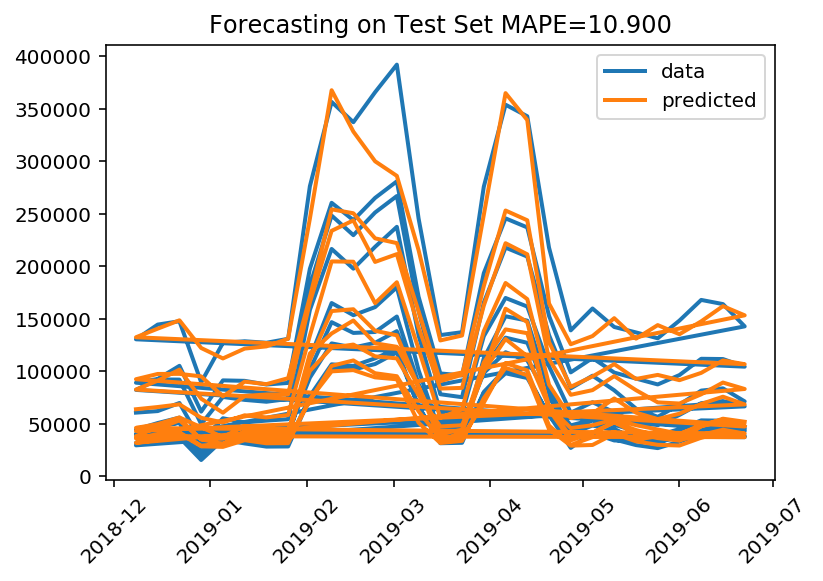

3
group_B


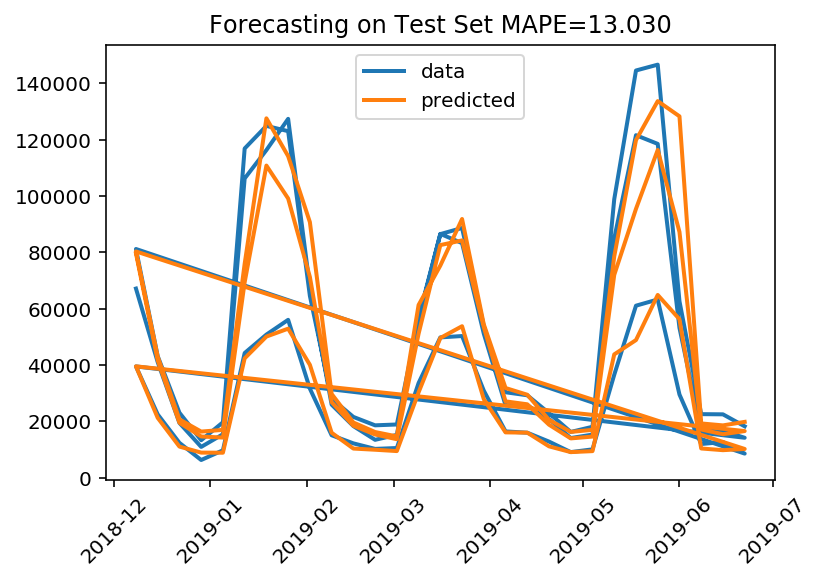

3
group_C


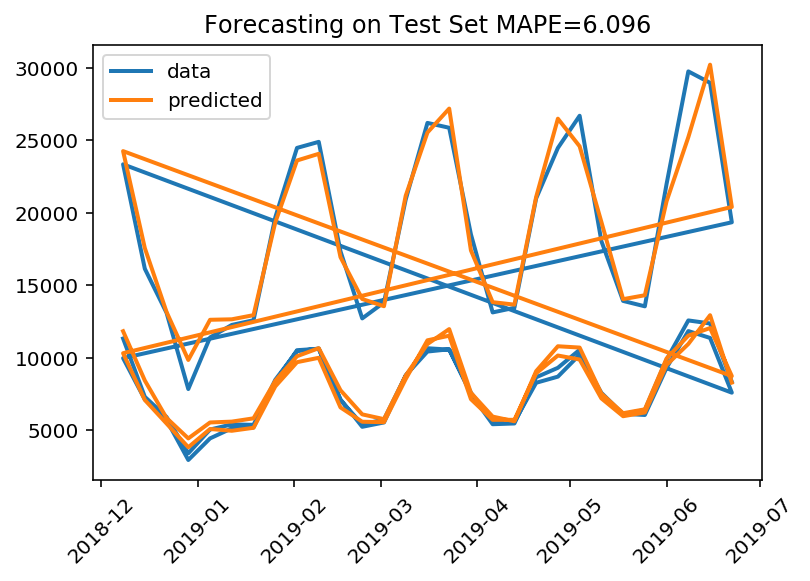

3
group_D


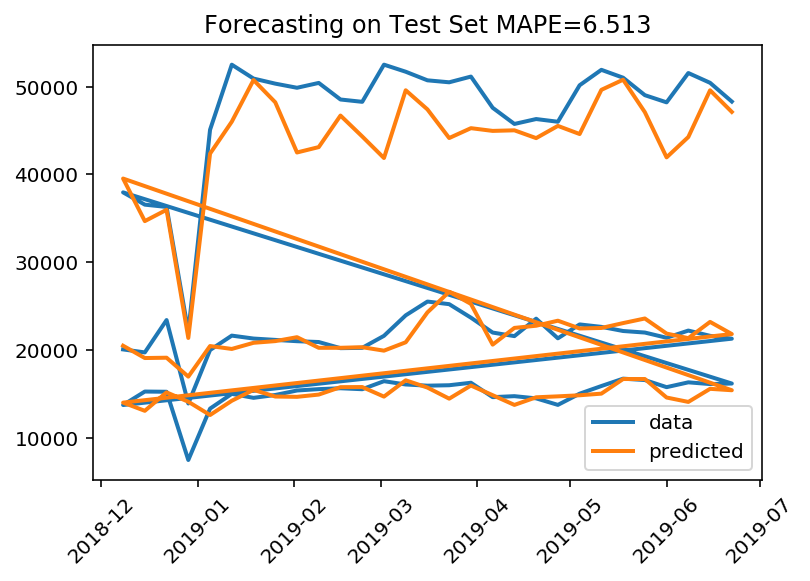

2
group_E


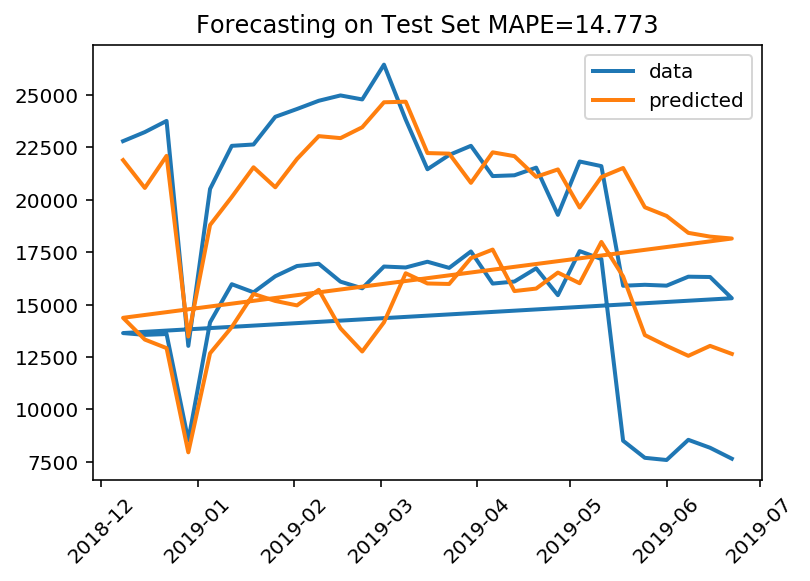

In [23]:
for g in groups:
    if g == "Not_grouped":
        continue
    y_traing = y_train.loc[X_train[g]]
    X_traing = X_train.loc[X_train[g]].drop(columns = groups)
    y_testg = y_test.loc[X_test[g]]
    X_testg = X_test.loc[X_test[g]].drop(columns = groups)
    
    
    sku_dummies = pd.get_dummies(y_traing["sku"]) > 0
    sku_dummies_df = pd.DataFrame(sku_dummies, index = X_traing.index)
    X_traing = pd.concat([sku_dummies_df,X_traing],axis = 1)

    sku_dummies = pd.get_dummies(y_testg["sku"]) > 0
    sku_dummies_df = pd.DataFrame(sku_dummies, index = X_testg.index)
    X_testg = pd.concat([sku_dummies_df,X_testg],axis = 1)

    
    
    model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.1)
    
    #xgb.XGBRegressor(n_estimators=500, learning_rate=0.1) #MAPE 10.9, 13.0, 6.09, 6.5, 14.77
    #CatBoostRegressor(iterations=500,learning_rate=0.1,eval_metric='MAPE') #MAPE =  11.1, 13.3, 7.6, 6.4,18
    #xgb.XGBRegressor(n_estimators=500, learning_rate=0.5) #MAPE 10.8, 14.9, 6.0, 6.4, 16.3
    #RandomForestRegressor(n_estimators=200,random_state=123) #MAPE 11.264, 12.636, 6.997, 6.387, 14.661
    #RandomForestRegressor(n_estimators=10,random_state=123) #MAPE 11.232, 11.994, 7.616, 6.068, 14.320

    
    model.fit(X_traing, y_traing["scaled_target"])

    prediction = model.predict(X_testg)

    results = pd.DataFrame(columns = ["date","sku","target","prediction"])

    for sku in y_testg["sku"].unique():

        pred_sku = prediction[np.where(y_testg["sku"] == sku)]
        originals = rescale_df.loc[rescale_df["sku"] == sku]["target"]
        pred = unscale(pred_sku,originals)

        results = pd.concat([results, pd.DataFrame({
            "date" : y_testg[y_testg["sku"] == sku]["date"],
            "sku" : y_testg[y_testg["sku"] == sku]["sku"],
            "target" : y_testg[y_testg["sku"] == sku]["target"],
            "prediction" : pred
        })])
    print(len(y_testg["sku"].unique()))

    print(g)
    results = results.dropna().set_index("date")

    plot_results(results["target"], results["prediction"], "target")


In [16]:
sku_not_grouped = y_train.loc[X_train["Not_grouped"]]["sku"].unique()
sku_not_grouped

array([2718, 1603, 1732, 2396])

29
2718


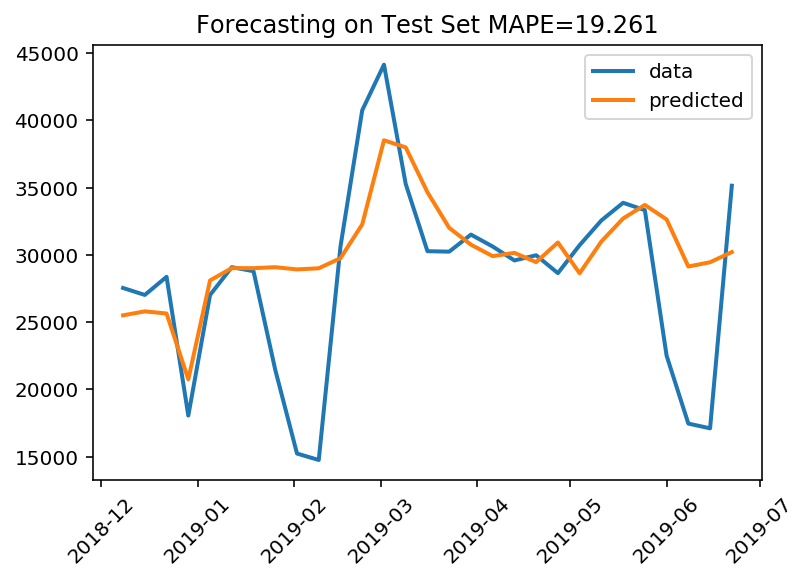

29
1603


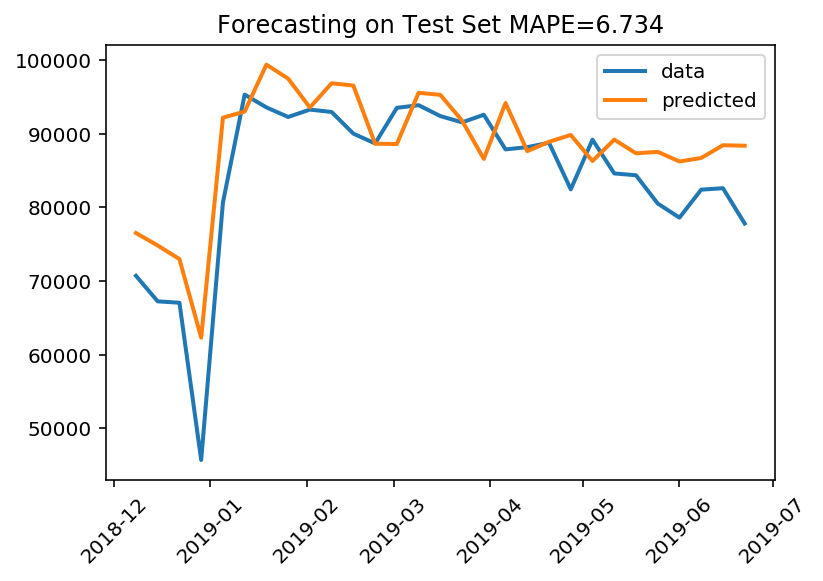

29
1732


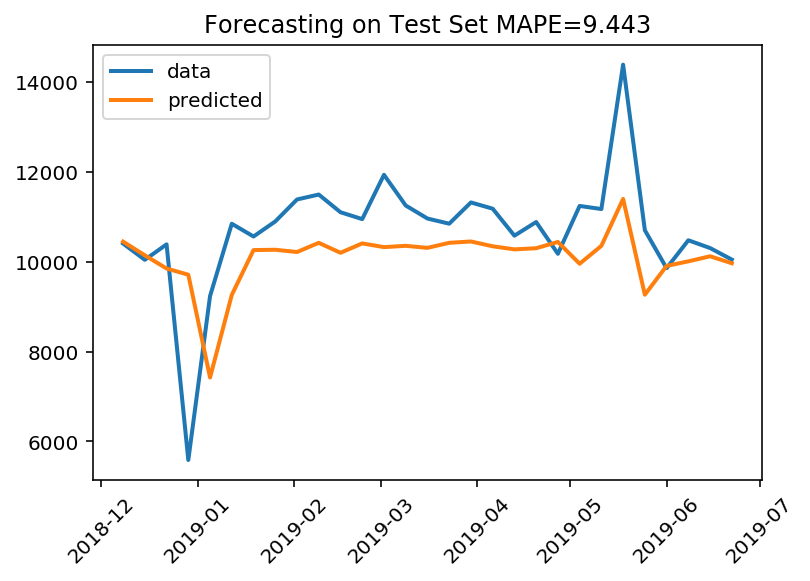

29
2396


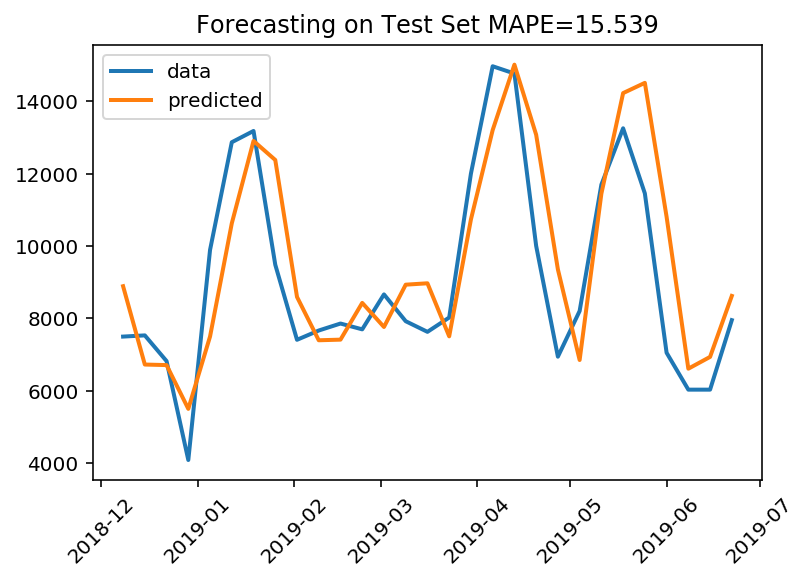

In [17]:
for s in sku_not_grouped:
    X_trains = X_train.loc[y_train.sku == s].drop(columns = groups)
    y_trains = y_train.loc[y_train.sku == s]
    X_tests = X_test.loc[y_test.sku == s].drop(columns = groups)
    y_tests = y_test.loc[y_test.sku == s]
     
    model = RandomForestRegressor(n_estimators=100,random_state=123) #MAPE 19.2, 6.7, 9.4, 15.5
    model.fit(X_trains, y_trains["scaled_target"])

    prediction = model.predict(X_tests)
    
    results = pd.DataFrame(columns = ["date","sku","target","prediction"])

    

    
    originals = rescale_df.loc[rescale_df["sku"] == s]["target"]
    pred = unscale(prediction,originals)

    results = pd.concat([results, pd.DataFrame({
        "date" : y_tests["date"],
        "sku" : y_tests["sku"],
        "target" : y_tests["target"],
        "prediction" : pred
    })])
    print(len(y_tests))

    print(s)
    results = results.dropna().set_index("date")

    plot_results(results["target"], results["prediction"], "target")
    
